<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from dataclasses import dataclass
import numpy as np
from scipy.constants import c as c_light
from scipy.integrate import quad
from scipy.special import exp1, expi, gammaincc
from scipy.special import comb
import logging
import matplotlib.pyplot as plt

from optic.comm.modulation import modulateGray, demodulateGray, grayMapping, detector
from optic.comm.metrics import fastBERcalc, theoryBER
from optic.models.channels import awgn
from optic.models.perturbation import perturbationNLIN
from optic.dsp.core import pnorm, signal_power
from optic.plot import pconst, plotDecisionBoundaries, randomCmap, plotColoredConst
from optic.utils import dB2lin, parameters
from numba import njit, prange

In [2]:
# @dataclass
# class PertCoeffParams:
#     alpha: float           # Attenuation [dB/km]
#     D: float               # Dispersion [ps/(nm.km)]
#     Fc: float              # CArrier Frequency [nm]
#     lspan: float           # Span length [km]
#     length: float          # Total link length [km]
#     matrixOrder: int       # Matrix order
#     pulseWidth: float      # Pulse width [s]
#     symbolPeriod: float    # Symbol period [s]
#     gamma: float           # Nonlinear coefficient [1/(W.km)]
#     powerWeighted: bool    # Use power weighted calculation?
#     powerWeightN: int = 3  # Order of power weighting (default = 3)

# def pert_coeff_matrix(param: PertCoeffParams):
#     # Setup logging
#     logging.basicConfig(level=logging.INFO)
#     log = logging.getLogger()
#     c_kms = c_light / 1e3
    
#     # Link parameters
#     λ = c_kms/param.Fc
#     alpha = param.alpha / (10 * np.log10(np.e))
#     beta2 = -param.D * λ**2 / (2 * np.pi * c_kms)
#     Leff = (1 - np.exp(-alpha * param.lspan)) / alpha
#     nSpans = int(param.length / param.lspan)

#     # Matrix indices
#     m_vals = np.arange(-param.matrixOrder, param.matrixOrder + 1)
#     M, N = np.meshgrid(m_vals, m_vals[::-1])

#     # Calculate C_ispm
#     constantIntegral = param.pulseWidth**4 / (3 * beta2**2)
#     fun1 = lambda z, c: 1.0 / np.sqrt(c + z**2)
#     C_ispm, _ = quad(lambda z: fun1(z, constantIntegral), 0, param.length)

#     # Calculate C_ifwm
#     if param.powerWeighted:
#         Acoeff = M * N * param.symbolPeriod**2 / beta2
#         sum1 = np.zeros_like(M, dtype=complex)
#         Norder = param.powerWeightN

#         log.info('Calculating matrix of perturbation coefficients (power-weighted)...')
#         for indSpan in range(1, nSpans + 1):
#             Bcoeff = -Norder / (alpha * Acoeff) + ((indSpan - 1) * param.lspan) / Acoeff

#             sum2 = np.zeros_like(M, dtype=complex)
#             for kk in range(1, Norder + 1):
#                 if indSpan != 1:
#                     GammaPrevious = gammaincc(1 - kk, 1j * (1 / Bcoeff - Acoeff / ((indSpan - 1) * param.lspan)))
#                 else:
#                     GammaPrevious = np.zeros_like(M, dtype=complex)
#                 GammaNext = gammaincc(1 - kk, 1j * (1 / Bcoeff - Acoeff / (indSpan * param.lspan)))

#                 term = (-1)**(kk + Norder) * comb(Norder - 1, kk - 1) * (1j / Bcoeff)**kk * (GammaPrevious - GammaNext)

#                 if kk == 1:
#                     sum2 = term
#                 else:
#                     sum2 += term

#             if indSpan == 1:
#                 sum1 = (np.exp(1j / Bcoeff) / Bcoeff**(Norder - 1)) * sum2
#             else:
#                 sum1 += (np.exp(1j / Bcoeff) / Bcoeff**(Norder - 1)) * sum2

#         C_ifwm = (Norder / alpha)**Norder * (Acoeff**-Norder) * sum1
#     else:
#         log.info('Calculating matrix of perturbation coefficients (standard)...')
#         C_ifwm = exp1(-1j * M * N * param.symbolPeriod**2 / (beta2 * param.length))

#     # Calculate C_ixpm
#     C_ixpm = 0.5 * exp1((N - M)**2 * param.symbolPeriod**2 * param.pulseWidth**2 / (3 * np.abs(beta2)**2 * param.length**2))
     
#     # Handle inf and nan values
#     if param.powerWeighted:
#         C_ifwm_mask = np.isnan(np.abs(C_ifwm)).astype(float)
#         C_ifwm[np.isnan(np.abs(C_ifwm))] = 0
#     else:
#         C_ifwm_mask = np.isinf(np.abs(C_ifwm)).astype(float)
#         C_ifwm[np.isinf(np.abs(C_ifwm))] = 0

#     C_ixpm[np.isinf(np.abs(C_ixpm))] = 0
#     C_ixpm = C_ifwm_mask * C_ixpm

#     # Scale the matrices
#     scale_factor = 1j * (8/9) * param.gamma * param.pulseWidth**2 / (np.sqrt(3) * np.abs(beta2)) * Leff / param.lspan
#     if param.powerWeighted:
#         C_ifwm = -(8/9) * param.gamma * param.pulseWidth**2 / (np.sqrt(3) * beta2) * C_ifwm
#         C_ixpm = scale_factor * C_ixpm
#         C_ispm = scale_factor * C_ispm
#     else:
#         C_ifwm = scale_factor * C_ifwm
#         C_ixpm = scale_factor * C_ixpm
#         C_ispm = scale_factor * C_ispm

#     # Combine results
#     C = C_ifwm + C_ixpm
#     C[param.matrixOrder, param.matrixOrder] = C_ispm

#     log.info('Matrix of perturbation coefficients calculated. Dimensions: %d x %d', 2 * param.matrixOrder + 1, 2 * param.matrixOrder + 1)

#     return C, C_ifwm, C_ixpm, C_ispm


# @njit(parallel=True)
# def additive_multiplicative_model_nlin_waveform(C_ifwm, C_ixpm, C_ispm, x, y, prec=np.complex128):
#     """
#     Calculates the perturbation-based additive and multiplicative NLIN for dual-polarization signals.

#     This function models nonlinear impairments in optical communication systems
#     considering intrachannel four-wave mixing (IFWM), intrachannel cross-phase modulation (IXPM),
#     and self-phase modulation (SPM) effects, using a memory-based convolution approach.
#     Optimized for high-speed execution with Numba JIT compilation and parallelization.

#     Parameters
#     ----------
#     C_ifwm : ndarray of shape (2L+1, 2L+1)
#         Nonlinear coefficient matrix for intrachannel four-wave mixing (IFWM).
    
#     C_ixpm : ndarray of shape (2L+1, 2L+1)
#         Nonlinear coefficient matrix for intrachannel cross-phase modulation (IXPM).
    
#     C_ispm : float
#         Scalar nonlinear coefficient for intrachannel self-phase modulation (SPM).
    
#     x : ndarray of shape (N,)
#         Input signal for polarization X (complex-valued).

#     y : ndarray of shape (N,)
#         Input signal for polarization Y (complex-valued).

#     prec : data-type, optional
#         Precision of the computation (`np.complex64` or `np.complex128`), by default `np.complex128`.

#     Returns
#     -------
#     dx : ndarray of shape (N,)
#         Nonlinear perturbation waveform for polarization X.
    
#     dy : ndarray of shape (N,)
#         Nonlinear perturbation waveform for polarization Y.

#     phi_ixpm_x : ndarray of shape (N,)
#         Phase rotation due to cross-phase modulation affecting polarization X.

#     phi_ixpm_y : ndarray of shape (N,)
#         Phase rotation due to cross-phase modulation affecting polarization Y.

#     Notes
#     -----
#     - The input signals `x` and `y` are normalized to have unit average power internally.
#     - The function uses a window-based convolution with precomputed matrices and masks.
#     - Requires `dot_numba` to perform dot products compatible with Numba.
#     - The function is highly optimized and runs in parallel across time indices.

#     """
#     L = (C_ifwm.shape[0] - 1) // 2
#     D = C_ifwm.shape[0] - 1

#     C = C_ifwm + C_ixpm
#     C[D, D] = C_ispm
#     C_m_non_equal_zero = C.copy()
#     C_m_non_equal_zero[:, L] = np.inf

#     mask_nonzero_T = np.isinf(C_m_non_equal_zero.T)
#     mask_nonzero = np.isinf(C_m_non_equal_zero)

#     C_ixpm_mask1 = (C_ixpm * mask_nonzero_T).ravel()
#     C_ixpm_mask2 = (C_ixpm * mask_nonzero).ravel()
#     C_ifwm_vec = C_ifwm.ravel()

#     # Normalize power
#     x = x / np.sqrt(np.mean(np.abs(x)**2))
#     y = y / np.sqrt(np.mean(np.abs(y)**2))

#     # Outputs
#     N = len(x)
#     dx = np.zeros(N, dtype=prec)
#     dy = np.zeros(N, dtype=prec)
#     phi_ixpm_x = np.zeros(N)
#     phi_ixpm_y = np.zeros(N)

#     # Prepad input
#     symbX = np.concatenate((np.zeros(D, dtype=prec), x, np.zeros(D, dtype=prec)))
#     symbY = np.concatenate((np.zeros(D, dtype=prec), y, np.zeros(D, dtype=prec)))

#     # Precompute indexes
#     indL = 2*L + 1    
#     M = np.zeros((indL, indL), dtype=np.int64)
#     for i in range(indL):
#         M[i, :] = np.arange(indL)
        
#     NplusM = -(M.T - L + M - L) + 2*L  
#     NplusM = NplusM = NplusM[:, ::-1] # rotate and flip on axis 0

#     n_idx = np.arange(-L, L + 1)

#     for t in prange(D, len(symbX) - D):
#         windowX = symbX[t - D:t + D + 1]
#         windowY = symbY[t - D:t + D + 1]

#         X_center = windowX[L:L+2*L+1]
#         Y_center = windowY[L:L+2*L+1]

#         Xm = np.empty((2*L+1, 2*L+1), dtype=prec)
#         Ym = np.empty((2*L+1, 2*L+1), dtype=prec)
#         Xn = np.empty((2*L+1, 2*L+1), dtype=prec)
#         Yn = np.empty((2*L+1, 2*L+1), dtype=prec)

#         for i in range(2*L+1):
#             for j in range(2*L+1):
#                 Xm[i, j] = X_center[j]
#                 Ym[i, j] = Y_center[j]
#                 Xn[i, j] = X_center[2*L - i]  # flipud
#                 Yn[i, j] = Y_center[2*L - i]  # flipud

#         X_NplusM = np.empty((2*L+1, 2*L+1), dtype=prec)
#         Y_NplusM = np.empty((2*L+1, 2*L+1), dtype=prec)

#         for i in range(2*L+1):
#             for j in range(2*L+1):
#                 X_NplusM[i, j] = windowX[NplusM[i, j]]
#                 Y_NplusM[i, j] = windowY[NplusM[i, j]]

#         Xm_conj_X_NplusM = Xm * np.conj(X_NplusM)
#         Ym_conj_Y_NplusM = Ym * np.conj(Y_NplusM)

#         DX = Xn * Xm_conj_X_NplusM + Yn * Ym_conj_Y_NplusM
#         DY = Yn * Ym_conj_Y_NplusM + Xn * Xm_conj_X_NplusM

#         Xm2 = np.abs(Xm)**2
#         Ym2 = np.abs(Ym)**2

#         Xm2_Ym2 = (2 * Xm2 + Ym2).ravel()
#         Ym2_Xm2 = (2 * Ym2 + Xm2).ravel()

#         phi_ixpm_x[t - D] = np.imag(
#             dot_numba(Xm2_Ym2, C_ixpm_mask1) + (np.abs(Xm[L, L])**2 + np.abs(Ym[L, L])**2) * C_ispm
#         )
#         phi_ixpm_y[t - D] = np.imag(
#             dot_numba(Ym2_Xm2, C_ixpm_mask1) + (np.abs(Ym[L, L])**2 + np.abs(Xm[L, L])**2) * C_ispm
#         )

#         dx[t - D] = dot_numba(DX.ravel(), C_ifwm_vec) + dot_numba((Yn * np.conj(Y_NplusM) * Xm).ravel(), C_ixpm_mask2)
#         dy[t - D] = dot_numba(DY.ravel(), C_ifwm_vec) + dot_numba((Xn * np.conj(X_NplusM) * Ym).ravel(), C_ixpm_mask2)

#     return dx, dy, phi_ixpm_x, phi_ixpm_y

# @njit
# def dot_numba(a, b):
#     """
#     Computes the dot product of two 1D arrays in a Numba-compatible way.

#     This function is equivalent to `np.dot` for 1D arrays but can be
#     JIT-compiled with Numba for accelerated execution.

#     Parameters
#     ----------
#     a : ndarray of shape (N,)
#         First input array (complex-valued).

#     b : ndarray of shape (N,)
#         Second input array (complex-valued).

#     Returns
#     -------
#     result : complex
#         The dot product of `a` and `b`, computed as the sum of element-wise products.

#     Notes
#     -----
#     - Both input arrays must have the same length.
#     - This function initializes the result as a complex number to support
#       complex-valued operations.
#     """
#     result = 0.0 + 0.0j  # complex number initialization
#     for i in range(len(a)):
#         result += a[i] * b[i]
#     return result

# @njit(parallel=True)
# def additive_multiplicative_model_nlin_waveform_red_complexity(C_ifwm, C_ixpm, C_ispm, x, y, coeff_tol=-20, prec=np.complex128):
#     """
#     Calculates the perturbation-based additive and multiplicative NLIN with reduced 
#     number of coefficients.

#     This function performs the additive-multiplicative model computation with 
#     complex-valued inputs `x` and `y`, using a reduced number of coefficients based on a 
#     specified tolerance for coefficient magnitude, to enhance computational efficiency.

#     Parameters
#     ----------
#     C_ifwm : ndarray of shape (M,)
#         Coefficient matrix for the Inverse Fourier-weighted filter model.

#     C_ixpm : ndarray of shape (M,)
#         Coefficient matrix for the Inverse XPM model.

#     C_ispm : scalar
#         Coefficient for the Inverse Single-Phase Modulation model.

#     x : ndarray of shape (N,)
#         Input signal for the X component (complex-valued).

#     y : ndarray of shape (N,)
#         Input signal for the Y component (complex-valued).

#     coeff_tol : float
#         Coefficient magnitude tolerance in dB. Coefficients with a magnitude 
#         below this threshold (in dB) are excluded from the calculation to reduce 
#         computational complexity. Default is -20 dB.

#     prec : dtype, optional
#         The precision of the computation. Default is `np.complex128`.

#     Returns
#     -------
#     dx : ndarray of shape (N,)
#         The computed result for the X component after processing.

#     dy : ndarray of shape (N,)
#         The computed result for the Y component after processing.

#     phi_ixpm_x : ndarray of shape (N,)
#         Phase information related to the XPM effect on the X component.

#     phi_ixpm_y : ndarray of shape (N,)
#         Phase information related to the XPM effect on the Y component.

#     Notes
#     -----
#     - The function reduces the number of coefficients used in the computation 
#       based on the provided `coeff_tol` value.
#     - The results are computed efficiently using parallelism and Numba's 
#       JIT compilation.
#     - The function assumes that the input arrays `x` and `y` are complex-valued 
#       and normalized.
#     """        
#     # Definitions
#     L = (len(C_ifwm) - 1) // 2
#     D = len(C_ifwm) - 1

#     C = C_ifwm + C_ixpm
#     C[D, D] = C_ispm
#     C_m_non_equal_zero = C.copy()
#     C_m_non_equal_zero[:, L] = np.inf
#     C_ixpm_mask1 = C_ixpm * np.isinf(C_m_non_equal_zero.T)
#     C_ixpm_mask2 = C_ixpm * np.isinf(C_m_non_equal_zero)
       
#     # Normalize power
#     x = x / np.sqrt(np.mean(np.abs(x)**2))
#     y = y / np.sqrt(np.mean(np.abs(y)**2))

#     # Pre-allocations
#     Nsymb = len(x)
#     dx = np.zeros(Nsymb, dtype=prec)
#     dy = np.zeros(Nsymb, dtype=prec)
#     phi_ixpm_x = np.zeros(Nsymb)
#     phi_ixpm_y = np.zeros(Nsymb)

#     symbX = np.zeros(Nsymb + 2*D, dtype=prec)
#     symbY = np.zeros(Nsymb + 2*D, dtype=prec)
#     symbX[D:-D] = x
#     symbY[D:-D] = y

#     # Indexing matrices
#     indL = 2*L + 1
#     M = np.zeros((indL, indL), dtype=np.int64)
#     for i in range(indL):
#         M[i, :] = np.arange(indL)
#     NplusM = -(M.T - L + M - L) + (2*L)    
#     NplusM = NplusM = NplusM[:, ::-1] # rotate and flip on axis 0
    
#     # Flatten
#     C_ixpm_mask1 = C_ixpm_mask1.flatten()
#     C_ixpm_mask2 = C_ixpm_mask2.flatten()
#     C_ifwm = C_ifwm.flatten()
#     C = C.flatten()

#     # Coefficient reduction
#     absC = np.abs(C)
#     maxC = np.max(absC)
#     n_reduced_coeff = np.sum(20 * np.log10(absC / maxC) > coeff_tol)
#     ind_sort = np.argsort(-absC)[:n_reduced_coeff]

#     C_ixpm_mask1 = C_ixpm_mask1[ind_sort]
#     C_ixpm_mask2 = C_ixpm_mask2[ind_sort]
#     C_ifwm = C_ifwm[ind_sort]
    
#     print('Number of used coefficients:', n_reduced_coeff)
#     print('Reduction of ', np.round(100 * (1 - n_reduced_coeff / len(C)), 2),'%')
#     print('Sum of squares of original matrix:', np.round(np.sum(np.abs(C)**2), 2))
#     print('Sum of squares of simplified matrix:',np.round(np.sum(np.abs(C[ind_sort])**2),2))
    
#     # Pre-allocate 2D arrays
#     Xm = np.zeros((indL, indL), dtype=prec)
#     Ym = np.zeros((indL, indL), dtype=prec)
#     Xn = np.zeros((indL, indL), dtype=prec)
#     Yn = np.zeros((indL, indL), dtype=prec)

#     x_2d = np.zeros(2*D + 1, dtype=prec)
#     y_2d = np.zeros(2*D + 1, dtype=prec)

#     max_iter = len(symbX)

#     for t in prange(D, max_iter - D):
#         if t == D:
#             for k in range(2*D+1):
#                 x_2d[k] = symbX[t - D + k]
#                 y_2d[k] = symbY[t - D + k]

#             X_NplusM = np.empty((indL, indL), dtype=prec)
#             Y_NplusM = np.empty((indL, indL), dtype=prec)
#             for i in range(indL):
#                 for j in range(indL):
#                     X_NplusM[i, j] = x_2d[NplusM[i, j]]
#                     Y_NplusM[i, j] = y_2d[NplusM[i, j]]

#             center = (len(x_2d) - 1) // 2
#             vec_x = x_2d[center - L:center + L + 1]
#             vec_y = y_2d[center - L:center + L + 1]

#             for i in range(indL):
#                 for j in range(indL):
#                     Xm[i, j] = vec_x[i]
#                     Ym[i, j] = vec_y[i]
#                     Xn[i, j] = vec_x[j]
#                     Yn[i, j] = vec_y[j]
#         else:
#             for k in range(2*D):
#                 x_2d[k] = x_2d[k+1]
#                 y_2d[k] = y_2d[k+1]
#             x_2d[-1] = symbX[t + D]
#             y_2d[-1] = symbY[t + D]

#             X_NplusM = np.empty((indL, indL), dtype=prec)
#             Y_NplusM = np.empty((indL, indL), dtype=prec)
#             for i in range(indL):
#                 for j in range(indL):
#                     X_NplusM[i, j] = x_2d[NplusM[i, j]]
#                     Y_NplusM[i, j] = y_2d[NplusM[i, j]]

#             Xm[:, :-1] = Xm[:, 1:]
#             Ym[:, :-1] = Ym[:, 1:]
#             for i in range(indL):
#                 Xm[i, -1] = x_2d[D+i-L]
#                 Ym[i, -1] = y_2d[D+i-L]

#             Xn[:-1, :] = Xn[1:, :]
#             Yn[:-1, :] = Yn[1:, :]
#             for j in range(indL):
#                 Xn[-1, j] = x_2d[D+j-L]
#                 Yn[-1, j] = y_2d[D+j-L]

#         # Flatten and select only significant terms
#         Xm_flat = Xm.flatten()[ind_sort]
#         Ym_flat = Ym.flatten()[ind_sort]
#         Xn_flat = Xn.flatten()[ind_sort]
#         Yn_flat = Yn.flatten()[ind_sort]
#         X_NplusM_flat = X_NplusM.flatten()[ind_sort]
#         Y_NplusM_flat = Y_NplusM.flatten()[ind_sort]

#         A1 = np.abs(Xm_flat)**2
#         A2 = np.abs(Ym_flat)**2
#         M1 = Xn_flat * np.conj(X_NplusM_flat)
#         M2 = Yn_flat * np.conj(Y_NplusM_flat)

#         DX = (M1 + M2) * Xm_flat
#         DY = (M2 + M1) * Ym_flat

#         phi_ixpm_x[t - D] = np.imag(dot_numba(2*A1 + A2, C_ixpm_mask1) + (np.abs(Xm_flat[0])**2 + np.abs(Ym_flat[0])**2) * C_ispm)
#         phi_ixpm_y[t - D] = np.imag(dot_numba(2*A2 + A1, C_ixpm_mask1) + (np.abs(Ym_flat[0])**2 + np.abs(Xm_flat[0])**2) * C_ispm)

#         dx[t - D] = dot_numba(DX, C_ifwm) + dot_numba(M2 * Xm_flat, C_ixpm_mask2)
#         dy[t - D] = dot_numba(DY, C_ifwm) + dot_numba(M1 * Ym_flat, C_ixpm_mask2)

#     return dx, dy, phi_ixpm_x, phi_ixpm_y


In [3]:
# # Examples
# params = PertCoeffParams(
#     alpha=0.2,
#     D = 17,
#     Fc = 193.1e12,     # km
#     lspan=50,
#     length=2000,
#     matrixOrder=75,
#     pulseWidth=0.5*1/32e9,
#     symbolPeriod=1/32e9,
#     gamma=1.3,
#     powerWeighted=False
# )

# C, C_ifwm, C_ixpm, C_ispm = pert_coeff_matrix(params)

# plt.figure()
# plt.imshow(np.abs(np.imag(C)))
# #plt.imshow(np.abs(C_ispm))

In [4]:
# Run simulation 
M   = 16  # order of the modulation format
constType = 'qam' # 'qam', 'psk', 'apsk', 'pam' or 'ook'

# generate random bits
bitsX = np.random.randint(2,size =int(np.log2(M)*50e3))
bitsY = np.random.randint(2,size =int(np.log2(M)*50e3))

# Map bits to constellation symbols
symbX = modulateGray(bitsX, M, constType)
symbY = modulateGray(bitsY, M, constType)

# normalize symbols energy to 1
symbX = pnorm(symbX)
symbY = pnorm(symbY)

In [5]:
import time

In [6]:
# Power = 3 # dBm

# start = time.time()
# dx, dy, phi_ixpm_x, phi_ixpm_y = additive_multiplicative_model_nlin_waveform(C_ifwm, C_ixpm, C_ispm, symbX, symbY, np.complex64)
# end = time.time()
# delay = end - start
# print(f'Conventional model: {delay:.4f} s')

# start = time.time()
# dx, dy, phi_ixpm_x, phi_ixpm_y = additive_multiplicative_model_nlin_waveform_red_complexity(C_ifwm, C_ixpm, C_ispm, symbX, symbY, -25, np.complex64)
# end = time.time()
# delay = end - start
# print(f'Reduced complexity model: {delay:.4f} s')

# Plaunch = 10**(Power / 10) * 1e-3  # Calcula a potência de lançamento em Watts
# PeakPower = 0.5 * Plaunch          # Potência de pico por polarização, em Watts

# deltaX = PeakPower**(3/2) * dx
# deltaY = PeakPower**(3/2) * dy
# phiX = PeakPower * phi_ixpm_x
# phiY = PeakPower * phi_ixpm_y

# nlinX = symbX * (np.exp(1j * phiX) - 1) + deltaX * np.exp(1j * phiX)
# nlinY = symbY * (np.exp(1j * phiY) - 1) + deltaY * np.exp(1j * phiY)

In [7]:
# rot = np.mean(symbX / (symbX + nlinX))

# symbX_r = np.exp(1j*np.angle(rot)) * (symbX + nlinX)

# pconst(symbX_r);

In [17]:
paramNLIN = parameters()
paramNLIN.mode = 'AM'
paramNLIN.Pin = 2
paramNLIN.coeffTol = -10
paramNLIN.lspan = 50
paramNLIN.length = 1600
paramNLIN.matrixOrder = 50

A = np.sqrt(10**(paramNLIN.Pin/10/2)*1e-3)

Ein = np.array([symbX, symbY]).T

start = time.time()
nlinA = perturbationNLIN(Ein, paramNLIN)
end = time.time()
delay = end - start
print(f'Conventional model: {delay:.4f} s')

paramNLIN.mode = 'AMR'
start = time.time()
nlinA = perturbationNLIN(Ein, paramNLIN)
end = time.time()
delay = end - start
print(f'Reduced complexity model: {delay:.4f} s')

INFO:root:Calculating matrix of perturbation coefficients (standard)...
INFO:root:Matrix of perturbation coefficients calculated. Dimensions: 101 x 101
INFO:root:Calculating matrix of perturbation coefficients (standard)...
INFO:root:Matrix of perturbation coefficients calculated. Dimensions: 101 x 101


Conventional model: 14.5030 s
Number of used coefficients: 1339
Reduction of  86.87 %
Sum of squares of original matrix: 15969.03
Sum of squares of simplified matrix: 14671.43
Reduced complexity model: 5.4230 s


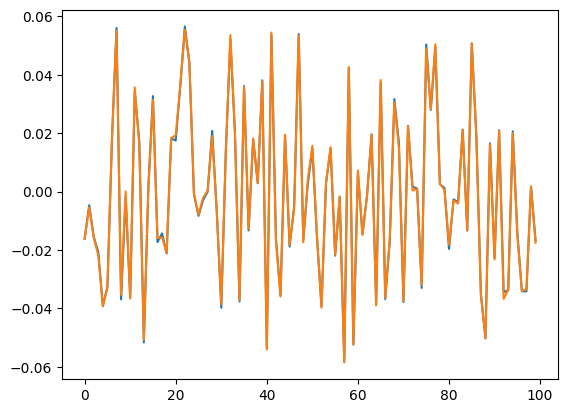

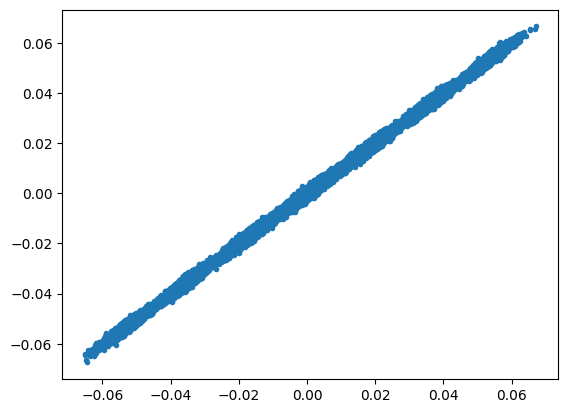

In [18]:
plt.figure()
plt.plot(nlinA[200:300,0].real, '-')
plt.plot(nlinB[200:300,0].real, '-')

plt.figure()
plt.plot(nlinA[:,0].imag, nlinB[:,0].imag,'.')

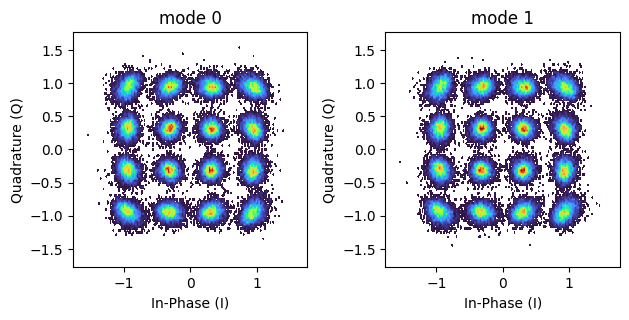

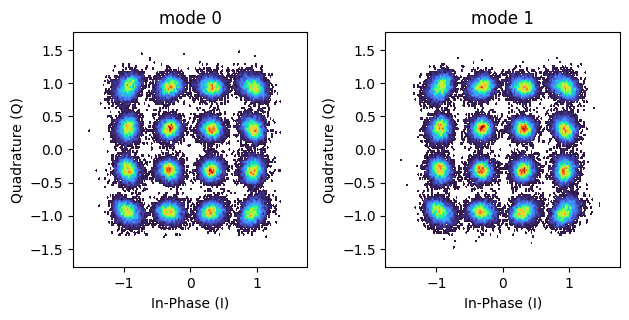

In [19]:
Eout = A*Ein + nlinA
rot = np.mean(Ein / Eout)
Eout = rot*Eout
pconst(Eout);

Eout = A*Ein + nlinB
rot = np.mean(Ein / Eout)
Eout = rot*Eout
pconst(Eout);